In [221]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numpy as np
import hvplot.pandas
import config;
from config import db_pw;
import psycopg2;

In [222]:
#establishing the connection
conn = psycopg2.connect(
   database="Predictive_Senescence_DB", user='postgres', password= db_pw, host='predictive-senescence-db.cbunnafql9ym.us-east-2.rds.amazonaws.com', port= '5432'
)

#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Retrieving data
cursor.execute('''SELECT * from birds_data_raw''')

#Fetching 1st row from the table
bird_df = pd.DataFrame(cursor.fetchall(), columns=["Collection_Num", "Bird_ID", "Sex", "Agey", "AgeClass", "BirthFPID", "U_PlateID", "RTL", "Technician", "Terr", "FPID", "Mum", "Dad", "Mac", "Pac", "BRF", "BRM"]);
print(bird_df)

#Commit your changes in the database
conn.commit()

#Closing the connection
conn.close()

      Collection_Num  Bird_ID  Sex       Agey AgeClass  BirthFPID U_PlateID  \
0                  1     5511    0   0.246575        J        103       9_3   
1                  2     5559    1   3.597260        A        103       9_1   
2                  3     5559    1   4.715068        A        103      9_28   
3                  4     5559    1   0.657534       SA        103       9_2   
4                  5     5527    1   0.328767      OFL        103       9_3   
...              ...      ...  ...        ...      ...        ...       ...   
2657            2658      221    1   6.958904        A          8       2_1   
2658            2659      216    1   8.947945        A          8       8_8   
2659            2660      176    1   6.772603        A          8      7_32   
2660            2661      221    1   9.090411        A          8      1_12   
2661            2662      176    1  13.873973        A          8       4_3   

       RTL  Technician   Terr  FPID   Mum   Dad    

In [223]:
max(bird_df["Agey"])

16.9369863

In [203]:
#Make a list to hold unique ID's found in bird_df
passover_list = [0,1]

#Make a DF to hold the overall change in Age and RTL for each bird
changeRate_df = pd.DataFrame(columns=["Bird_ID", "Age_Change", "RTL_Change", "Rate_Of_Change"])

#Iterate once for each row in the bird_df
for i in range(len(bird_df["Bird_ID"])):
    #If the Bird_ID in this row is not in our passover list (already processed), continue
    if(bird_df.loc[i,"Bird_ID"] not in passover_list):

        #Initialize indexer for next row(s) and make a DF to hold all duplicate ID's, their ages and RTL values
        k = i+1
        holder_df = pd.DataFrame({"ID": [bird_df.loc[i,"Bird_ID"]], "Age": [bird_df.loc[i, "Agey"]], "RTL": [bird_df.loc[i,"RTL"]]})

        #Loop through all rows with matching ID's
        while(bird_df.loc[k,"Bird_ID"] == bird_df.loc[i,"Bird_ID"]):
            #Place matching rows data into holder_DF and incriment indexer
            holder_df = holder_df.append({"ID": bird_df.loc[k,"Bird_ID"], "Age": bird_df.loc[k, "Agey"], "RTL": bird_df.loc[k,"RTL"]}, ignore_index=True)
            k = k+1
        #We are only interested in birds with multiple collections -- this is to identify rate of change in telomere
        if(len(holder_df) > 1):
            max_age = 0
            min_age = 0
            final_rtl = 0
            first_rtl = 0
            for row in holder_df.iterrows():
                id = row[1].ID
                if(row[1].Age == max(holder_df["Age"])):
                    max_age = row[1].Age
                    final_rtl = row[1].RTL
                    high_ratio = row[1].Age / row[1].RTL
                elif(row[1].Age == min(holder_df["Age"])):
                    min_age = row[1].Age
                    first_rtl = row[1].RTL
                    low_ratio = row[1].Age / row[1].RTL
            age_change = max_age - min_age
            rtl_change = final_rtl - first_rtl
            change_rate = high_ratio - low_ratio
            # change_rate = rtl_change/age_change
            changeRate_df = changeRate_df.append({"Bird_ID": id, "Age_Change": age_change, "RTL_Change": rtl_change, "Rate_Of_Change": change_rate}, ignore_index=True)
        # else:
        #     changeRate_df = changeRate_df.append({"Bird_ID": holder_df.loc[0,"ID"], "Age_Change": holder_df.loc[0, "Age"], "RTL_Change": holder_df.loc[0,"RTL"]}, ignore_index=True)
        passover_list.append(bird_df.loc[i,"Bird_ID"])

changeRate_df.head(10)

,Bird_ID,Age_Change,RTL_Change,Rate_Of_Change
0,5559.0,4.057534,0.08,3.742430
1,5539.0,1.306849,-0.25,4.378696
2,5536.0,3.920548,0.49,3.726865
3,5549.0,1.931507,0.12,3.506638
4,5509.0,0.986301,0.02,1.164622
5,5573.0,1.019178,0.29,0.739316
6,5534.0,1.142466,0.41,0.710567
7,5553.0,1.309589,0.42,1.145793
8,5652.0,0.427397,-0.22,1.048654
9,5547.0,3.432877,0.18,3.232219


In [204]:
changeRate_df["Rate_Of_Change"].corr(changeRate_df["Age_Change"])

0.6680730414244922

In [205]:
changeRate_df.count()

Bird_ID           561
Age_Change        561
RTL_Change        561
Rate_Of_Change    561
dtype: int64

In [206]:
changeRate_df = changeRate_df.loc[changeRate_df["Rate_Of_Change"] > -5]

In [207]:
changeRate_df = changeRate_df.loc[changeRate_df["Rate_Of_Change"] < 13.5]

In [208]:
changeRate_df

,Bird_ID,Age_Change,RTL_Change,Rate_Of_Change
0,5559.0,4.057534,0.08,3.742430
1,5539.0,1.306849,-0.25,4.378696
2,5536.0,3.920548,0.49,3.726865
3,5549.0,1.931507,0.12,3.506638
4,5509.0,0.986301,0.02,1.164622
...,...,...,...,...
556,5465.0,1.887671,-1.64,2.846451
557,5313.0,2.484932,0.04,3.400752
558,5529.0,1.961644,0.14,1.600231
559,5531.0,1.378082,0.03,1.542952


<AxesSubplot:>

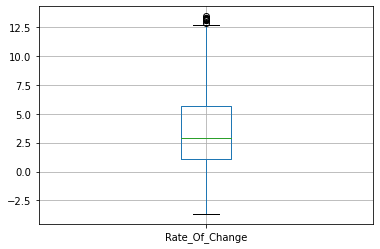

In [209]:
changeRate_df.boxplot("Rate_Of_Change")

<AxesSubplot:xlabel='Rate_Of_Change', ylabel='Age_Change'>

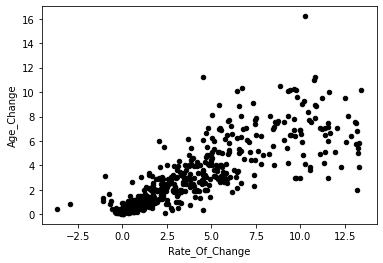

In [210]:
changeRate_df.plot.scatter(x='Rate_Of_Change', y='Age_Change', color='Black')

In [211]:
changeRate_df["Age_Change"].corr(changeRate_df["Rate_Of_Change"])

0.8100562480494256

In [212]:
x = changeRate_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=changeRate_df.columns)

<AxesSubplot:xlabel='RTL_Change', ylabel='Age_Change'>

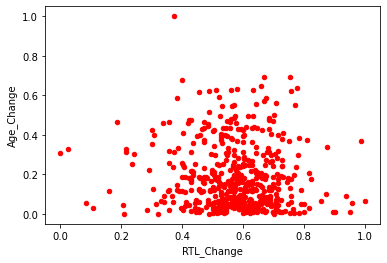

In [213]:
df.plot.scatter(x='RTL_Change', y='Age_Change', color='Red')

<AxesSubplot:xlabel='RTL_Change', ylabel='Age_Change'>

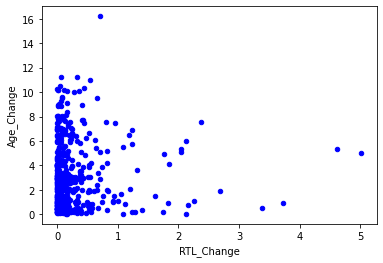

In [214]:
quad_df = changeRate_df.copy()
quad_df["RTL_Change"] = changeRate_df["RTL_Change"] * changeRate_df["RTL_Change"]
quad_df.plot.scatter(x='RTL_Change', y='Age_Change', color='Blue')

In [215]:
quad_df["RTL_Change"].corr(quad_df["Age_Change"])

0.029681902886933332

In [216]:
log_df = changeRate_df.copy()

In [217]:
log_df["RTL_Change"] = np.log(changeRate_df["RTL_Change"] + 5)

<AxesSubplot:xlabel='RTL_Change', ylabel='Age_Change'>

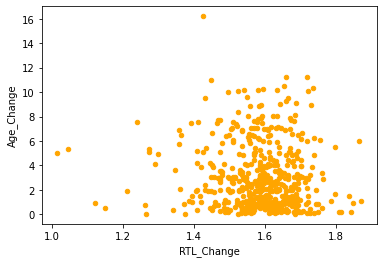

In [218]:
log_df.plot.scatter(x='RTL_Change', y='Age_Change', color='Orange')

In [219]:
log_df["RTL_Change"].corr(log_df["Age_Change"])

-0.06947434358578508

<AxesSubplot:xlabel='RTL_Change', ylabel='Age_Change'>

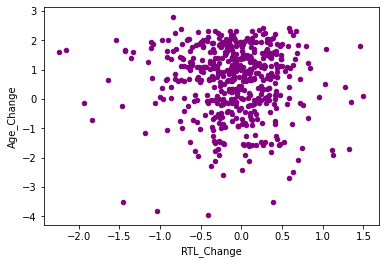

In [220]:
log_age_df = changeRate_df.copy()
log_age_df["Age_Change"] = np.log(changeRate_df["Age_Change"])
log_age_df.plot.scatter(x='RTL_Change', y='Age_Change', color='Purple')